#Building a neural network to predict antibody V-gene classes from heavy chain sequence embeddings generated by Ablang

A neural network was trained on heavy chain sequence embeddings generated using the Ablang protein language model. The embeddings were used as features to predict heavy chain V-gene usage, determined by ANARCI, an empirical but computationally intensive method to annotate antibody sequences.

The model was trained by using the following approach:

1.   Import/install dependencies
2.   Read in embeddings and associated metadata
3.   Convert heavy chain V-gene metadata to an encoded class label
4.   One-hot encode the class label
5.   Split the embeddings and labels into training, validation and testing sets
6.   Build and train the model using a simple neural network architecture
7.   Validate the model on the validation set, and finally the testing set to ensure no data leak has occured
8.   Save the model


In [ ]:
#@title Mount drive and load libraries { display-mode: "form" }
import os
from google.colab import drive
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt, seaborn as sns

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/'
os.chdir(path)

In [ ]:
tensor_df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230810_ablang_tensor_40000.csv', index_col=0)
tensor_test = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230809_ablang_tensor_10000.csv', index_col=0)
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)

In [ ]:
#@title Generate encoded labels
labels = df['v_call_heavy'].apply(lambda x: x.split('*')[0])
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

df['IGHV_ID'] = labels
df.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_human_paired_seqs.csv')

In [ ]:
#@title One-hot encode labels
num_classes = len(np.unique(labels))
labels_encoded = to_categorical(labels, num_classes=num_classes)

embeddings = pd.concat([tensor_test.iloc[:,:-1], tensor_df.iloc[:,:-1]])
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.780141,-0.001989,-0.582361,-0.147043,-0.086769,0.880245,0.809031,-0.436034,-0.498808,-0.057695,...,-0.130151,0.844303,0.185571,0.376737,-0.461052,-0.050956,-0.322840,0.105922,0.654003,0.437458
1,-0.573974,0.168763,-0.626173,-0.383275,-0.263363,0.965270,0.674030,-0.165210,-0.545409,0.430296,...,-0.105820,0.297973,-0.347124,0.621849,-0.316913,-0.202655,-0.073860,0.041968,0.190206,0.631538
2,-0.621966,-0.165467,-0.736313,-0.319382,0.004470,0.587106,0.623679,-0.176842,-0.627610,0.085860,...,0.131062,0.515072,-0.513537,0.528391,-0.203666,0.014801,-0.019266,0.406789,0.392878,0.644978
3,-0.498222,0.448086,-0.454136,-0.335476,0.105656,0.934464,0.819091,-0.297037,-0.448911,0.690701,...,0.128698,0.313065,-0.373647,0.519711,-0.632641,-0.078901,-0.362466,-0.052095,0.455051,0.774456
4,-0.369197,0.943716,-0.232305,-0.179607,-0.440741,0.299502,0.685887,-0.307812,-0.887387,0.622613,...,0.513967,-0.242578,-0.470876,0.621298,-0.456812,0.453724,0.210269,-0.234133,0.730512,0.945041


In [ ]:
#@title Split embeddings into training, validation and testing sets
X_train = embeddings.iloc[:35000, :]
y_train = labels_encoded[:35000, :]

X_val = embeddings.iloc[35000:45000, :]
y_val = labels_encoded[35000:45000, :]

X_test = embeddings.iloc[45000:50000,:]
y_test = labels_encoded[45000:50000,:]

In [ ]:
#@title Build and train model
def build_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#build model
model = build_model(X_train.shape[1], num_classes)

#train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1094/1094 [==============================] - 18s 16ms/step - loss: 0.4790 - accuracy: 0.8736 - val_loss: 0.0988 - val_accuracy: 0.9608
Epoch 2/10
1094/1094 [==============================] - 23s 21ms/step - loss: 0.0881 - accuracy: 0.9722 - val_loss: 0.1103 - val_accuracy: 0.9619
Epoch 3/10
1094/1094 [==============================] - 24s 22ms/step - loss: 0.0759 - accuracy: 0.9770 - val_loss: 0.1135 - val_accuracy: 0.9612
Epoch 4/10
1094/1094 [==============================] - 22s 20ms/step - loss: 0.0763 - accuracy: 0.9761 - val_loss: 0.1816 - val_accuracy: 0.9588
Epoch 5/10
1094/1094 [==============================] - 19s 17ms/step - loss: 0.0659 - accuracy: 0.9805 - val_loss: 0.0909 - val_accuracy: 0.9651
Epoch 6/10
1094/1094 [==============================] - 14s 13ms/step - loss: 0.0731 - accuracy: 0.9776 - val_loss: 0.0684 - val_accuracy: 0.9646
Epoch 7/10
1094/1094 [==============================] - 14s 12ms/step - loss: 0.0549 - accuracy: 0.9843 - val_loss: 0.1113 -

313/313 [==============================] - 1s 4ms/step
Accuracy: 0.9667

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00       287
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00       229
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00        83
          10       1.00      1.00      1.00       219
          11       1.00      1.00      1.00        29
          12       1.00      1.00      1.00       171
          13       1.00      1.00      1.00        39
          14       1.00      1.00      1.00       334
          15       1.00      1.00     

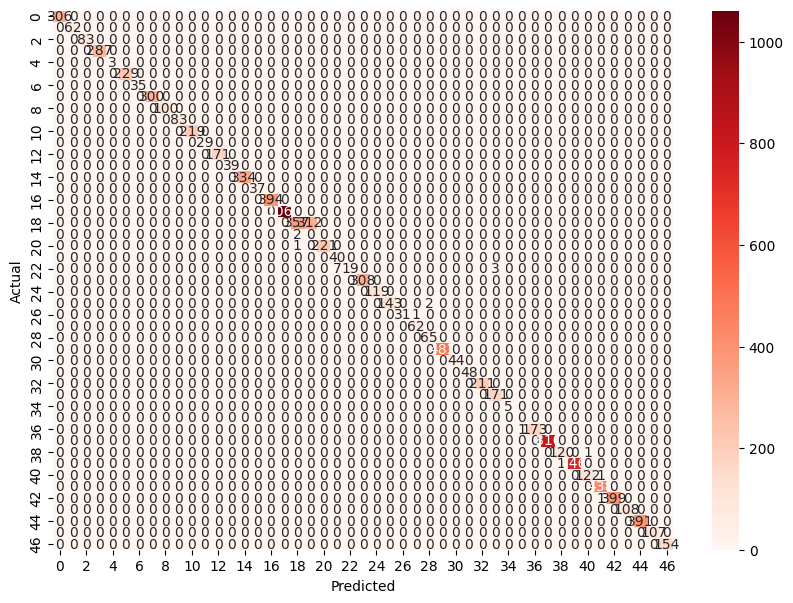

In [ ]:
#@title Assess model on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

157/157 [==============================] - 1s 5ms/step
Accuracy: 0.972

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00       101
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00       124
           8       1.00      1.00      1.00        54
           9       1.00      1.00      1.00        35
          10       1.00      1.00      1.00       121
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00        99
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00       150
          15       1.00      1.00      

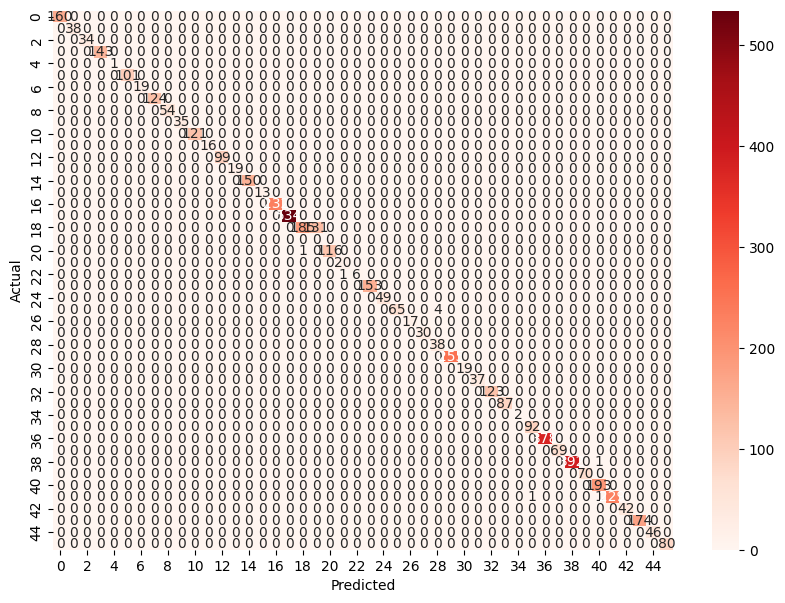

In [ ]:
#@title Assessing the model on totally unseen data

#Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#Basic Metrics
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

#Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/ablang_V_gene_model.h5')